# The Mathematical Engineering of Deep Learning

by Benoit Liquet, Sarat Moka, and Yoni Nazarathy

Julia Jupyter Notebook for [Unit 5](https://deeplearningmath.org/convolutional-neural-networks.html).



In [22]:
using Metalhead

#downloads about 0.5Gb of a pretrained neural network from the web
vgg = VGG19();
for (i,layer) in enumerate(vgg.layers)
    println(i,":\t", layer)
end

1:	Conv((3, 3), 3=>64, relu)
2:	Conv((3, 3), 64=>64, relu)
3:	MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2))
4:	Conv((3, 3), 64=>128, relu)
5:	Conv((3, 3), 128=>128, relu)
6:	MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2))
7:	Conv((3, 3), 128=>256, relu)
8:	Conv((3, 3), 256=>256, relu)
9:	Conv((3, 3), 256=>256, relu)
10:	Conv((3, 3), 256=>256, relu)
11:	MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2))
12:	Conv((3, 3), 256=>512, relu)
13:	Conv((3, 3), 512=>512, relu)
14:	Conv((3, 3), 512=>512, relu)
15:	Conv((3, 3), 512=>512, relu)
16:	MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2))
17:	Conv((3, 3), 512=>512, relu)
18:	Conv((3, 3), 512=>512, relu)
19:	Conv((3, 3), 512=>512, relu)
20:	Conv((3, 3), 512=>512, relu)
21:	MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2))
22:	#44
23:	Dense(25088, 4096, relu)
24:	Dropout(0.5)
25:	Dense(4096, 4096, relu)
26:	Dropout(0.5)
27:	Dense(4096, 1000)
28:	softmax


In [23]:
vgg.layers[22]

#44 (generic function with 1 method)

..............................
Model1 (Dense) accuracy = 0.9366
Model2 (Convolutional) accuracy = 0.9628


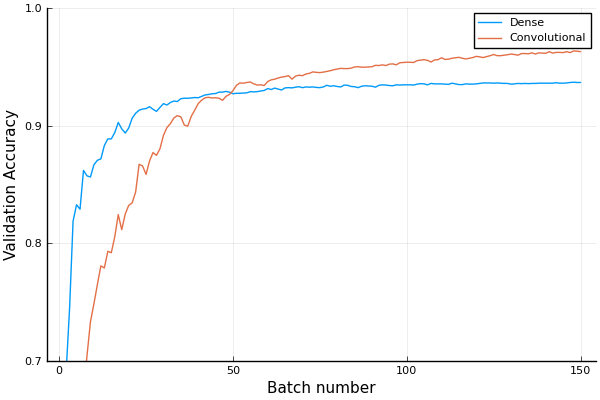

In [13]:
using Flux, Flux.Data.MNIST, Statistics, BSON, Random, Plots; pyplot()
using Flux: onehotbatch, onecold, crossentropy
Random.seed!(0)

epochs = 30
η = 5e-3
batchSize = 1000
trainRange, validateRange = 1:5000, 5001:10000

function minibatch(x, y, indexRange)
    xBatch = Array{Float32}(undef, size(x[1])..., 1, length(indexRange))
    for i in 1:length(indexRange)
        xBatch[:, :, :, i] = Float32.(x[indexRange[i]])
    end
    return (xBatch, onehotbatch(y[indexRange], 0:9))
end

trainLabels = MNIST.labels()[trainRange]
trainImgs = MNIST.images()[trainRange]
mbIdxs = Iterators.partition(1:length(trainImgs), batchSize)
trainSet = [minibatch(trainImgs, trainLabels, bi) for bi in mbIdxs]

validateLabels = MNIST.labels()[validateRange]
validateImgs = MNIST.images()[validateRange]
validateSet = minibatch(validateImgs, validateLabels, 1:length(validateImgs))

model1 = Chain(   flatten, 
                  Dense(784, 200, relu),
                  Dense(200, 100, tanh),
                  Dense(100, 10), 
                  softmax)

model2 = Chain(   Conv((5, 5),1=>8,relu,stride=(1,1),pad=(0,0)), 
                  MaxPool((2,2)),
                  Conv((3, 3),8=>16,relu,stride=(1,1),pad=(0,0)), 
                  MaxPool((2,2)),
                  flatten, 
                  Dense(400, 10), 
                  softmax)

opt1 = ADAM(η); opt2 = ADAM(η)
accuracyPaths = [[],[]]
accuracy(x, y, model) = mean(onecold(model(x)) .== onecold(y))
loss(x, y, model) = crossentropy(model(x), y)
cbF1() = push!(accuracyPaths[1],accuracy(validateSet..., model1))
cbF2() = push!(accuracyPaths[2],accuracy(validateSet..., model2))

model1(trainSet[1][1]); model2(trainSet[1][1])
for _ in 1:epochs
    Flux.train!((x,y)->loss(x,y,model1), params(model1), trainSet, opt1, cb=cbF1)
    Flux.train!((x,y)->loss(x,y,model2), params(model2), trainSet, opt2, cb=cbF2)
	print(".")
end

println("\nModel1 (Dense) accuracy = ", accuracy(validateSet..., model1))
println("Model2 (Convolutional) accuracy = ", accuracy(validateSet..., model2))
cd(@__DIR__)
BSON.@save "mnistConv.bson" modelParams=cpu.(params(model2))
plot(accuracyPaths,label = ["Dense" "Convolutional"],
	ylim=(0.7,1.0), xlabel="Batch number", ylabel = "Validation Accuracy")